<a href="https://colab.research.google.com/github/Lexaun-chen/STAT-4830-Group-Project/blob/main/notebooks/Demo%E2%80%94%E2%80%94Adam_Netflix_Problem_Matrix_completion_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# === Core Libraries ===
import math
import numpy as np
import pandas as pd
import requests

# === PyTorch ===
import torch
import torch.nn as nn
import torch.nn.functional as F

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Evaluation Metrics ===
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using device: cuda


In [3]:
def set_seed(seed=123):
    """
    Set random seed for reproducibility across NumPy and PyTorch (CPU & GPU).

    Args:
        seed (int): The seed value to use for random number generation.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)          # For single-GPU setups
    torch.cuda.manual_seed_all(seed)      # For multi-GPU setups

    torch.backends.cudnn.deterministic = True  # Ensures deterministic results
    torch.backends.cudnn.benchmark = False     # Disables cuDNN auto-tuner for reproducibility

set_seed(123)

### Get Netflix Dataset

In [7]:
# Rating information
rate_url = "https://raw.githubusercontent.com/Lexaun-chen/STAT-4830-Group-Project/main/tests/ratings.dat"
response = requests.get(rate_url)
lines = response.text.strip().split('\n')

ratings_list = [line.split("::") for line in lines]
ratings_df = pd.DataFrame(ratings_list, columns=['UserID', 'MovieID', 'Rating', 'Timestamp']).astype(int)

ratings = ratings_df[['UserID', 'MovieID', 'Rating']]

ratings.head()

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [8]:
# Movie information for recommendation system
film_url = 'https://raw.githubusercontent.com/Lexaun-chen/STAT-4830-Group-Project/main/tests/movies.dat'
response = requests.get(film_url)
lines = response.text.strip().split('\n')

film_list = [line.split("::") for line in lines]
movies_df = pd.DataFrame(film_list, columns=['MovieID', 'Title', 'Genres'])
movies_df['MovieID'] = movies_df['MovieID'].astype(int)

movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
R_df = ratings_df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating')
user_ids = sorted(ratings_df['UserID'].unique())
movie_ids = sorted(ratings_df['MovieID'].unique())

R = R_df.values
user_ratings_mean = np.nanmean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

TR_demeaned = torch.tensor(R_demeaned, dtype=torch.float32, device='cuda')
TR = torch.tensor(R, dtype=torch.float32, device='cuda')

In [10]:
TR

tensor([[5., nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [3., nan, nan,  ..., nan, nan, nan]], device='cuda:0')

In [11]:
num_valid = (~torch.isnan(TR)).sum().item()
print(f"The number of non-nan elements: {num_valid}")
valid_ratio = (~torch.isnan(TR)).sum().float() / TR.numel()
print(f"The rate of non-nan elements: {valid_ratio}")

The number of non-nan elements: 1000209
The rate of non-nan elements: 0.04468362405896187


In [12]:
def create_train_test_split(X, num_test=2500, seed=123):
    observed_idx = torch.nonzero(~torch.isnan(X), as_tuple=False)
    perm = torch.randperm(observed_idx.size(0), generator=torch.Generator().manual_seed(seed))
    test_idx = observed_idx[perm[:num_test]]

    # Generate training data: Set the test score to NaN (Note: It cannot be set to 0)
    X_train = X.clone()
    X_train[test_idx[:, 0], test_idx[:, 1]] = float('nan')

    # Extract the real scores of the test set
    train_mask = ~torch.isnan(X_train) # True where value is observed
    test_ratings = X[test_idx[:, 0], test_idx[:, 1]]

    return X_train, train_mask, test_idx, test_ratings

In [13]:
class Netflix_MF_Adam(nn.Module):
    def __init__(self,  X_train, train_mask, k):
        super().__init__()
        self.device = X_train.device
        self.X = X_train
        self.k = k

        self.m, self.n = X_train.shape


        # Create observation mask
        self.mask = train_mask
        self.n_obs = self.mask.sum().item()
        scale = 1.0 / math.sqrt(k)

        # Latent factors
        self.U = nn.Parameter(torch.randn(self.m, k, device=self.device) * 0.02)
        self.V = nn.Parameter(torch.randn(self.n, k, device=self.device) *0.02)

        # Bias terms

        # Global bias
        mean_value = torch.nanmean(X_train).item()
        self.b = nn.Parameter(torch.tensor(mean_value, dtype=torch.float32, device=self.device))

        # User initial bias = User mean - Global mean
        user_means = torch.nanmean(X_train, dim=1)
        self.b_u = nn.Parameter((user_means - mean_value).clone().detach())

        # Item initial bias = Item mean - Global mean
        item_means = torch.nanmean(X_train, dim=0)
        self.b_v = nn.Parameter((item_means - mean_value).clone().detach())


    def forward(self):
        pred = self.b + self.b_u[:, None] + self.b_v[None, :] + self.U @ self.V.T
        return pred


    def train_loss(self, loss_type="mse", l2_lambda=1e-4, huber_delta=1.0):
          """
          Computes masked loss + optional L2 regularization.

          Parameters:
              loss_type (str): "mse", "mae", or "huber"
              l2_lambda (float): L2 regularization weight (default=1e-4)
              huber_delta (float): delta for Huber loss (default=1.0)

          Returns:
              torch scalar loss
          """
          pred = self.forward()
          true = self.X[self.mask]
          pred = pred[self.mask]

          if loss_type == "mse":
              loss = F.mse_loss(pred, true)
          elif loss_type == "mae":
              loss = F.l1_loss(pred, true)
          elif loss_type == "huber":
              loss = F.huber_loss(pred, true, delta=huber_delta)
          else:
              raise ValueError(f"Unsupported loss type: {loss_type}")

          # L2 regularization
          reg = l2_lambda * (self.U.norm() ** 2 + self.V.norm() ** 2)/self.n_obs

          return loss + reg


    def full_matrix(self):
          return self.forward().detach()

    def evaluate_train_rmse(self):
          pred = self.forward()[self.mask]
          true = self.X[self.mask]
          return F.mse_loss(pred, true).sqrt().item()

    def filled_matrix(self, pred_matrix=None):
          """
          Returns a matrix where observed entries are from self.X,
          and missing entries (where self.mask == False) are filled from prediction.
          """
          if pred_matrix is None:
              pred_matrix = self.forward().detach()

          filled = self.X.clone().detach()
          filled[~self.mask] = pred_matrix[~self.mask]
          return filled

In [18]:
def plot_history(history):
    history = np.array(history)
    epochs = history[:, 0]
    train_loss = history[:, 1]
    train_rmse = history[:, 2]
    test_rmse = history[:, 3]

    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    axs[0].plot(epochs, train_loss, label="Train Loss (MSE)", marker='o', color='steelblue')
    axs[0].set_ylabel("Loss")
    axs[0].set_title("Training Loss over Epochs")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(epochs, train_rmse, label="Train RMSE", marker='o', color='orange')
    axs[1].plot(epochs, test_rmse, label="Test RMSE", marker='s', color='green')
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("RMSE")
    axs[1].set_title("Train vs Test RMSE")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

In [14]:
def train_and_evaluate(X_train, train_mask, test_idx, test_ratings,
                       k=5, epochs=200, lr=1e-2, wd=0,
                       loss_type="mse", l2_lambda=1e-4,
                       verbose=True, plot=False,
                       save_model_path=None):
    """
    Trains MF_Adam on training data and evaluates on test set.

    Parameters:
        X_train (torch.Tensor): Training rating matrix (test positions = NaN)
        train_mask (torch.BoolTensor): True where training values are known
        test_idx (LongTensor): N x 2 tensor of (i, j) test positions
        test_ratings (FloatTensor): Ground truth ratings at test positions
        k (int): Latent dimension
        epochs (int): Training epochs
        lr (float): Learning rate
        wd (float): Weight decay
        verbose (bool): Whether to print progress

    Returns:
        history (list): List of (epoch, train_loss, test_rmse)
        X_hat (tensor): Final completed rating matrix
    """
    device = X_train.device
    model = Netflix_MF_Adam(X_train, train_mask, k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    history = []

    best_rmse = float("inf")
    best_epoch = 0
    patience = 10
    min_delta = 1e-5
    early_stop = False

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Train loss on masked observed entries
        train_loss = model.train_loss(loss_type=loss_type, l2_lambda=l2_lambda)
        train_loss.backward()
        optimizer.step()

        # Evaluation (no grad)
        model.eval()
        with torch.no_grad():
            pred_matrix = model.forward()
            test_preds = pred_matrix[test_idx[:, 0], test_idx[:, 1]]
            test_rmse = F.mse_loss(test_preds, test_ratings).sqrt().item()

        train_rmse = model.evaluate_train_rmse()
        history.append((epoch, train_loss.item(), train_rmse, test_rmse))

        if verbose and ((epoch+1) % 10 == 0 ):
            print(f"b_u mean: {model.b_u.mean().item():.4f} | U norm: {model.U.norm().item():.4f}")
            print(f"Epoch {epoch + 1} | Train Loss: {train_loss.item():.6f} | Test RMSE: {test_rmse:.6f}")

        if test_rmse + min_delta < best_rmse:
            best_rmse = test_rmse
            best_epoch = epoch
            best_weights = model.state_dict()  # 保存权重
        else:
            if epoch - best_epoch >= patience:
                print(f"Early stopping at epoch {epoch + 1}. Best RMSE: {best_rmse:.6f} at epoch {best_epoch + 1}")
                early_stop = True
                break

    model.load_state_dict(best_weights)
    X_hat = model.full_matrix()
    X_hat_clip = torch.clamp(X_hat, min=1.0, max=5.0)

    if save_model_path:
        torch.save(model.state_dict(), save_model_path)
        print(f"✅ Model saved to: {save_model_path}")

    if plot:
        plot_history(history)

    print(f"\n Training completed. Best Test RMSE: {best_rmse:.6f} at epoch {best_epoch + 1}.")


    return history, X_hat, X_hat_clip, best_rmse, best_epoch



In [19]:
def run_grid_search(X_train, train_mask, test_idx, test_ratings,
                    k_list=[10, 20, 30],
                    l2_list=[1e-4, 5e-4, 1e-3],
                    loss_types=["mse", "huber"],
                    lr_list=[5e-4, 1e-3, 2e-3],
                    epochs=300,
                    plot_best=True,
                    verbose=False):
    """
    Grid search over MF_Adam hyperparameters.

    Parameters:
        X_train, train_mask, test_idx, test_ratings: training/test data tensors
        k_list: latent dimension values
        l2_list: L2 regularization values
        loss_types: loss function names
        lr_list: learning rates
        epochs: training epochs per run
        plot_best: whether to plot training curve for best model
        verbose: whether to print all training logs

    Returns:
        results_df: pandas DataFrame of results
    """
    results = []
    best_rmse_overall = float("inf")
    best_history = None

    total_runs = len(k_list) * len(l2_list) * len(loss_types) * len(lr_list)
    run_counter = 0

    for lr in lr_list:
        for k in k_list:
            for l2 in l2_list:
                for loss_type in loss_types:
                    run_counter += 1
                    print(f"\n🔍 [{run_counter}/{total_runs}] Training: "
                          f"k={k}, λ={l2}, loss={loss_type}, lr={lr}")

                    history, X_hat, X_hat_clip, best_rmse, best_epoch = train_and_evaluate(
                        X_train, train_mask, test_idx, test_ratings,
                        k=k, epochs=epochs, lr=lr,
                        loss_type=loss_type, l2_lambda=l2,
                        plot=False, verbose=verbose
                    )

                    results.append({
                        "k": k,
                        "l2_lambda": l2,
                        "loss_type": loss_type,
                        "lr": lr,
                        "best_rmse": round(best_rmse, 6),
                        "best_epoch": best_epoch + 1
                    })

                    if plot_best and best_rmse < best_rmse_overall:
                        best_rmse_overall = best_rmse
                        best_history = history

    results_df = pd.DataFrame(results).sort_values(by="best_rmse").reset_index(drop=True)

    print("\n🏁 Grid search complete. Top 5 results:\n")
    print(results_df.head(5).to_string(index=False))

    # if plot_best and best_history is not None:
    #     plot_history(best_history)

    return results_df

### Train-test split & Grid search for hyperparameter tuning

In [20]:
X_train, train_mask, test_idx, test_ratings = create_train_test_split(TR)

k_list = [20, 30, 50]
l2_list = [1e-4, 5e-4, 1e-3]
loss_types = ["mse","huber"]
lr_list = [1e-3, 5e-3, 1e-2]

results_df = run_grid_search(
    X_train, train_mask, test_idx, test_ratings,
    k_list=k_list,
    l2_list=l2_list,
    loss_types=loss_types,
    lr_list=lr_list,
    epochs=300,
    plot_best=True,
    verbose=False
)


🔍 [1/54] Training: k=20, λ=0.0001, loss=mse, lr=0.001
Early stopping at epoch 241. Best RMSE: 0.865261 at epoch 231

 Training completed. Best Test RMSE: 0.865261 at epoch 231.

🔍 [2/54] Training: k=20, λ=0.0001, loss=huber, lr=0.001
Early stopping at epoch 227. Best RMSE: 0.866171 at epoch 217

 Training completed. Best Test RMSE: 0.866171 at epoch 217.

🔍 [3/54] Training: k=20, λ=0.0005, loss=mse, lr=0.001
Early stopping at epoch 225. Best RMSE: 0.868105 at epoch 215

 Training completed. Best Test RMSE: 0.868105 at epoch 215.

🔍 [4/54] Training: k=20, λ=0.0005, loss=huber, lr=0.001
Early stopping at epoch 230. Best RMSE: 0.866077 at epoch 220

 Training completed. Best Test RMSE: 0.866077 at epoch 220.

🔍 [5/54] Training: k=20, λ=0.001, loss=mse, lr=0.001
Early stopping at epoch 234. Best RMSE: 0.868852 at epoch 224

 Training completed. Best Test RMSE: 0.868852 at epoch 224.

🔍 [6/54] Training: k=20, λ=0.001, loss=huber, lr=0.001
Early stopping at epoch 247. Best RMSE: 0.868325 at

b_u mean: 0.1182 | U norm: 9.4799
Epoch 10 | Train Loss: 0.849226 | Test RMSE: 0.917075
b_u mean: 0.1155 | U norm: 11.8908
Epoch 20 | Train Loss: 0.843230 | Test RMSE: 0.914315
b_u mean: 0.1128 | U norm: 15.1526
Epoch 30 | Train Loss: 0.836555 | Test RMSE: 0.911569
b_u mean: 0.1102 | U norm: 19.0170
Epoch 40 | Train Loss: 0.828598 | Test RMSE: 0.908619
b_u mean: 0.1078 | U norm: 23.3468
Epoch 50 | Train Loss: 0.818834 | Test RMSE: 0.905196
b_u mean: 0.1054 | U norm: 28.0335
Epoch 60 | Train Loss: 0.806961 | Test RMSE: 0.901135
b_u mean: 0.1033 | U norm: 32.9762
Epoch 70 | Train Loss: 0.793006 | Test RMSE: 0.896463
b_u mean: 0.1013 | U norm: 38.0769
Epoch 80 | Train Loss: 0.777361 | Test RMSE: 0.891440
b_u mean: 0.0995 | U norm: 43.2343
Epoch 90 | Train Loss: 0.760697 | Test RMSE: 0.886463
b_u mean: 0.0979 | U norm: 48.3462
Epoch 100 | Train Loss: 0.743742 | Test RMSE: 0.881912
b_u mean: 0.0964 | U norm: 53.3253
Epoch 110 | Train Loss: 0.727034 | Test RMSE: 0.877984
b_u mean: 0.0951 | U

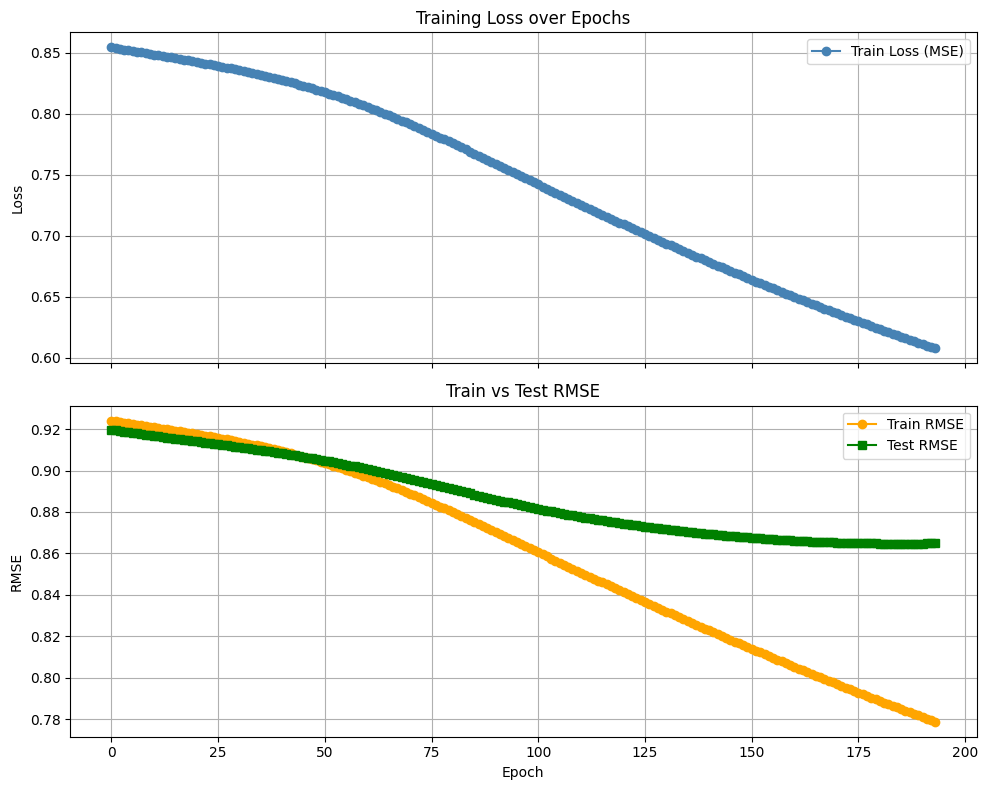


 Training completed. Best Test RMSE: 0.864713 at epoch 184.


In [21]:
history, X_hat, X_hat_clip, best_rmse, best_epoch = train_and_evaluate(
    X_train, train_mask, test_idx, test_ratings,
    k=30, epochs=300, lr=1e-3,
    loss_type="mse", l2_lambda=5e-4,
    plot=True,
    save_model_path=None
)


## Final Completion Result visualization & Top-10 Movie Recommender

In [22]:
# Derive final complete matrix
X_hat_np = X_hat.cpu().numpy()
df_hat = pd.DataFrame(X_hat_np, index=user_ids, columns=movie_ids)

X_hat_clip_np = X_hat_clip.cpu().numpy()
df_hat_clip = pd.DataFrame(X_hat_clip_np, index=user_ids, columns=movie_ids)

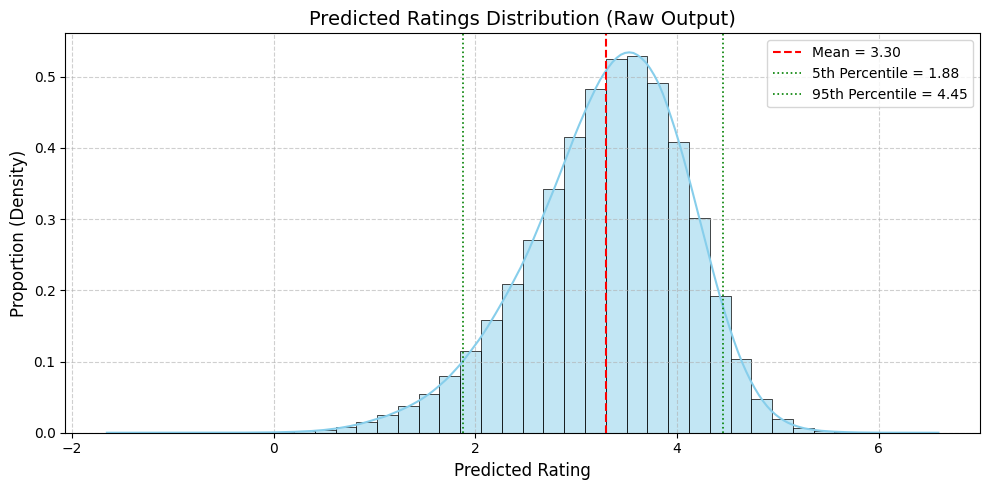

In [23]:
comp_matrix = X_hat.cpu().numpy().flatten()
mean_pred = np.mean(comp_matrix)
p5, p95 = np.percentile(comp_matrix, [5, 95])

plt.figure(figsize=(10, 5))
sns.histplot(comp_matrix, bins=40, kde=True, color="skyblue", stat="density", edgecolor="black", linewidth=0.5)
plt.axvline(mean_pred, color="red", linestyle="--", linewidth=1.5, label=f"Mean = {mean_pred:.2f}")
plt.axvline(p5, color="green", linestyle=":", linewidth=1.2, label=f"5th Percentile = {p5:.2f}")
plt.axvline(p95, color="green", linestyle=":", linewidth=1.2, label=f"95th Percentile = {p95:.2f}")
plt.title("Predicted Ratings Distribution (Raw Output)", fontsize=14)
plt.xlabel("Predicted Rating", fontsize=12)
plt.ylabel("Proportion (Density)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

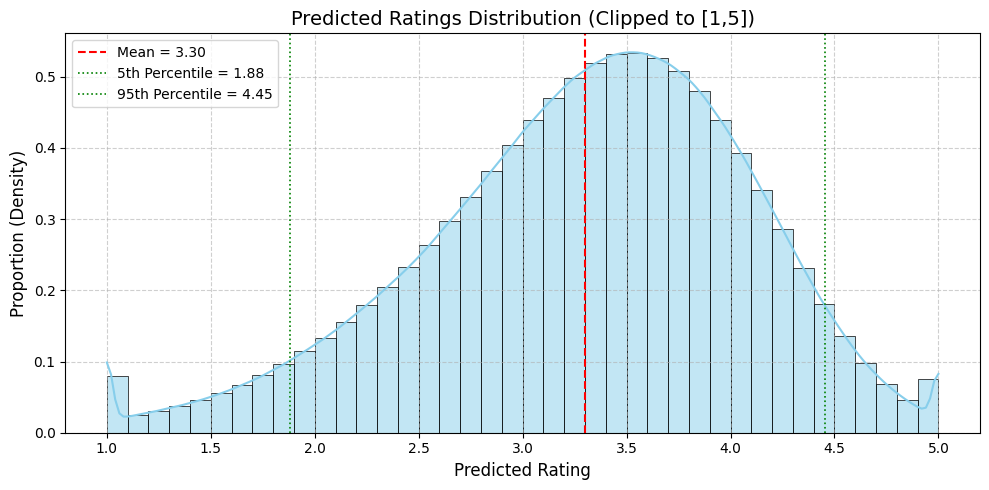

In [24]:
clip_matrix = X_hat_clip.cpu().numpy().flatten()
mean_pred = np.mean(clip_matrix)
p5, p95 = np.percentile(clip_matrix, [5, 95])

plt.figure(figsize=(10, 5))
sns.histplot(clip_matrix, bins=40, kde=True, color="skyblue", stat="density", edgecolor="black", linewidth=0.5)
plt.axvline(mean_pred, color="red", linestyle="--", linewidth=1.5, label=f"Mean = {mean_pred:.2f}")
plt.axvline(p5, color="green", linestyle=":", linewidth=1.2, label=f"5th Percentile = {p5:.2f}")
plt.axvline(p95, color="green", linestyle=":", linewidth=1.2, label=f"95th Percentile = {p95:.2f}")
plt.title("Predicted Ratings Distribution (Clipped to [1,5])", fontsize=14)
plt.xlabel("Predicted Rating", fontsize=12)
plt.ylabel("Proportion (Density)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [25]:
def recommend_top_k(comp_df, ratings_df, user_id, k=10):
    rated_movies = set(ratings_df[ratings_df['UserID'] == user_id]['MovieID'])
    user_scores = comp_df.loc[user_id]
    recs = user_scores[~user_scores.index.isin(rated_movies)]
    top_k = recs.sort_values(ascending=False).head(k)
    return top_k

top_k_series = recommend_top_k(df_hat, ratings_df, user_id=12, k=10)
top_k_df = top_k_series.reset_index()
top_k_df.columns = ['MovieID', 'PredictedRating']
top_k_merged = top_k_df.merge(movies_df[['MovieID', 'Title', 'Genres']], on='MovieID', how='left')
top_k_merged = top_k_merged[['MovieID', 'Title', 'PredictedRating']]
print(top_k_merged)

   MovieID                                      Title  PredictedRating
0     3382                     Song of Freedom (1936)         5.148074
1     2503                    Apple, The (Sib) (1998)         5.111025
2     2905                             Sanjuro (1962)         5.059006
3      989  Schlafes Bruder (Brother of Sleep) (1995)         5.053826
4     1830                    Follow the Bitch (1998)         4.988894
5     3233                       Smashing Time (1967)         4.972132
6     3607                   One Little Indian (1973)         4.959514
7      787         Gate of Heavenly Peace, The (1995)         4.935729
8     3280                           Baby, The (1973)         4.908016
9     3656                               Lured (1947)         4.904409
